# Adaptive model detection (AMD) with constrained gradient predictive state representation (PSR) predictor

## Setup, imports, initialisation

### Importing

In [1]:
import numpy as np
import torch
import math
from adaptive_model_detection import amd
from tqdm.notebook import tqdm

### Environments

Some sample environments are included in the `environments` folder. More environments and guidance on how to make your own that integrate with this code is included in [this repository](https://www.github.com/jupilogy/pomdp-tools "JupiLogy's POMDP tools").

In [2]:
from environments.pomdps import ENVX, ENVY

environment1 = ENVX
environment2 = ENVY

### Seed
Optionally, run with a seed of 0 to replicate figure 7 from the paper.

In [3]:
np.random.seed(0)

### Predictor and core tests
We use the [constrained gradient algorithm](http://papers.nips.cc/paper/2883-online-discovery-and-learning-of-predictive-state-representations.pdf) to learn a predictive state representation of the environment. This predictive state representation encodes the predictions of future events.

Core tests can be discovered by the constrained gradient algorithm over time, but for the purpose of this paper, we provided them in advance.

In [4]:
core1 = [np.empty((0, 2)), np.array([[0, 1]])]
core2 = [np.empty((0, 2)), np.array([[0, 1]])]


from agents.psr import const_grad

cg1 = const_grad(1,
                 2,
                 n=1000000,
                 learning_rate=0.5,
                 halving_interval=2000,
                 h_len=200,
                 core_t=core1)
cg2 = const_grad(1,
                 2,
                 n=1000000,
                 learning_rate=0.5,
                 halving_interval=2000,
                 h_len=200,
                 core_t=core2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### AMD trackers
`hlen` for AMD should be quite long for an accurate p-value. A smaller p-value means the agent detects changes faster. In general, a more complex environment should be given a longer `hlen`.

In [5]:
amd1 = amd([[0.5, 0.5]], 1, 2, h_len=100)
amd2 = amd([[0.5, 0.5]], 1, 2, h_len=100)

### PSR for error reference
In order to determine the accuracy of the agent, we compare its prediction at each timestep against an accurate PSR. This is not used by the learning agent. The error is calculated by taking the average prediction error over 10000 timesteps, independent from the data the agent learned on.

In [6]:
from accuracy import amd_psr_error

### Data generation
Generating data which switches between the environments.

In [7]:
from environments.datagen import random_traverse

data1 = random_traverse(10000, environment1)
data2 = random_traverse(10000, environment2)
rest_of_data = np.append(
    random_traverse(5000, environment1),
    np.append(
        random_traverse(5000, environment2),
        np.append(
            random_traverse(5000, environment1),
            random_traverse(5000, environment2),
            axis=0),
        axis=0),
    axis=0)

### Results storage

We will store the error of the agents and their p-values over time in these arrays.

In [8]:
error_array1 = []
error_array2 = []
pvals1 = []
pvals2 = []

## Training

### Which agent is trained?

If the agent is not given a minimum amount of training in each environment, it will not learn the environment well enough for AMD to accurately predict if the predictions are accurate. Therefore, for the first 10000 timesteps in each environment, the trained agent is manually selected.

After this "supervised" phase, the agent with the highest p-value is trained. If both p-values are below 5%, neither agent is trained.

### Why is error only calculated every 100 timesteps?

The error calculation is expensive. Therefore, we only calculate it every 100 timesteps. You can adjust this to be more often if you would like.

In [9]:
# For first 10k ts, no learning for agent 2
for i in range(data1.shape[0]-1):
    # Step the agents and get their predictions for the next a, o pair
    cg1.step(*data1[i])
    s1 = [[cg1.get_est(a, o) for o in range(amd1.o)] for a in range(amd1.a)]
    cg2.no_learn_step(*data1[i])
    s2 = [[cg2.get_est(a, o) for o in range(amd2.o)] for a in range(amd2.a)]
    
    # Step AMD trackers
    amd1.step(s1, *data1[i])
    amd2.step(s2, *data1[i])
    
    # Get agents' p-values
    pvals1.append(amd1.p_val)
    # Set agent 2's p-vals to 0 until we start training it
    pvals2.append(0)

    if i % 100 == 0:
        # Calculate error
        error_array1.append(amd_psr_error(environment1, cg1))
        error_array2.append(amd_psr_error(environment1, cg2))

# For second 10k ts, no learning for agent 1
for i in range(data2.shape[0]-1):
    # Step the agents and get their predictions for the next a, o pair
    cg1.no_learn_step(*data2[i])
    s1 = [[cg1.get_est(a, o) for o in range(amd1.o)] for a in range(amd1.a)]
    cg2.step(*data2[i])
    s2 = [[cg2.get_est(a, o) for o in range(amd2.o)] for a in range(amd2.a)]
    
    # Step AMD trackers
    amd1.step(s1, *data2[i])
    amd2.step(s2, *data2[i])
    
    # Get agents' p-values
    pvals1.append(amd1.p_val)
    pvals2.append(amd2.p_val)

    if i % 100 == 0:
        # Calculate error
        error_array1.append(amd_psr_error(environment2, cg1))
        error_array2.append(amd_psr_error(environment2, cg2))
        
# From then on, no learning for agent with lowest probability.
for i in range(rest_of_data.shape[0]-1):
    if amd1.p_val > amd2.p_val:
        # Step agents (with agent 2 not learning) and get predictions for next a, o pair
        if amd1.p_val > 0.001:
            cg1.step(*rest_of_data[i])
        else:
            cg1.no_learn_step(*rest_of_data[i])
        s1 = [[cg1.get_est(a, o) for o in range(amd1.o)] for a in range(amd1.a)]
        cg2.no_learn_step(*rest_of_data[i])
        s2 = [[cg2.get_est(a, o) for o in range(amd2.o)] for a in range(amd2.a)]
    elif amd2.p_val > amd1.p_val:
        # Step agents (with agent 1 not learning) and get predictions for next a, o pair
        if amd2.p_val > 0.001:
            cg2.step(*rest_of_data[i])
        else:
            cg2.no_learn_step(*rest_of_data[i])
        s2 = [[cg2.get_est(a, o) for o in range(amd1.o)] for a in range(amd1.a)]
        cg1.no_learn_step(*rest_of_data[i])
        s1 = [[cg1.get_est(a, o) for o in range(amd2.o)] for a in range(amd2.a)]
    else:
        # Step agents (with both or neither agents learning)
        if amd1.p_val > 0.001:
            cg1.step(*rest_of_data[i])
            cg2.step(*rest_of_data[i])
        else:
            cg1.no_learn_step(*rest_of_data[i])
            cg2.no_learn_step(*rest_of_data[i])
        # and get predictions for next a, o pair
        s1 = [[cg1.get_est(a, o) for o in range(amd1.o)] for a in range(amd1.a)]
        s2 = [[cg2.get_est(a, o) for o in range(amd2.o)] for a in range(amd2.a)]
    
    if i % 100 == 0:
        # Calculate error (according to current environment)
        if i < 5000 or 10000 <= i <= 15000:
            error_array1.append(amd_psr_error(environment1, cg1))
            error_array2.append(amd_psr_error(environment1, cg2))
        else:
            error_array1.append(amd_psr_error(environment2, cg1))
            error_array2.append(amd_psr_error(environment2, cg2))

    # Step AMD trackers
    amd1.step(s1, *rest_of_data[i])
    amd2.step(s2, *rest_of_data[i])

    # Get agents' p-values
    pvals1.append(amd1.p_val)
    pvals2.append(amd2.p_val)

## Data output

In [10]:
import matplotlib.pyplot as plt

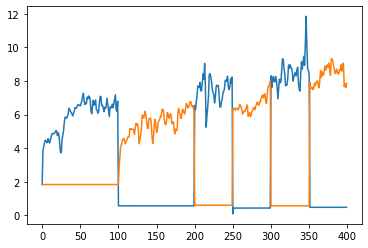

In [11]:
perf1 = [-math.log(x) for x in error_array1]
perf2 = [-math.log(x) for x in error_array2]

plt.plot(perf1)
plt.plot(perf2)
plt.show()

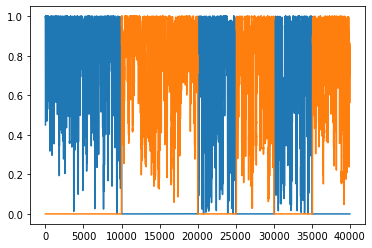

In [12]:
plt.plot(pvals1)
plt.plot(pvals2)
plt.show()